In [ ]:
# %% Convert the large xlsx file into a faster csv file - this takes some time..!
import dask
import pandas as pd
import numpy as np
import dask.dataframe as ddf
from dask.delayed import delayed
from sklearn.utils import axis0_safe_slice

convert_xlsx_to_csv = False

if convert_xlsx_to_csv:
    parts = dask.delayed(pd.read_excel)("Example_MLE.xlsx")
    df_per_dask = ddf.from_delayed(parts)
    df_per_dask.to_csv("Example_MLE.csv", single_file = True)

In [ ]:
# %% Load the data
df_raw = pd.read_csv("Example_MLE.csv",
                        index_col = 0,
                        low_memory= False
                    )
df_raw

In [ ]:
# %% Split the data into BOLD BIN part and the habitat data

column_names = df_raw.keys()
habitat_types = ["agricultural", "Forest", "Grassland", "Urban"]

habitat_columns = [col for col in column_names for habitat_type in habitat_types if habitat_type in col]
non_habitat_columns = [col for col in column_names if not col in habitat_columns]

df_BOLD_raw = pd.DataFrame(df_raw.loc[4:,non_habitat_columns]).copy().fillna("")
df_BOLD_raw.rename(columns = {old_col_name : new_col_name for old_col_name, new_col_name in zip(non_habitat_columns,df_raw.loc[3,non_habitat_columns])}, inplace=True)
df_habitat_raw = df_raw[habitat_columns].fillna(0)

In [ ]:
# %% Make dataframe BOLD nicer:
# - shorten the column "BOLD_BIN_uri"
# - split and shorten the column "OTU_ID;cluster_size"
# - add column "sum_reads_per_OTU"

df_BOLD_all = df_BOLD_raw.drop(["BOLD_BIN_uri", "OTU_ID;cluster_size"], axis = 1)

df_BOLD_all["BOLD_BIN_uri"] = [str(uri.replace("BOLD:", "")) for uri in  df_BOLD_raw['BOLD_BIN_uri']]
df_BOLD_all[["OTU_ID", "cluster_size"]] = df_BOLD_raw["OTU_ID;cluster_size"].str.split(";",expand=True,)
df_BOLD_all["OTU_ID"] = [id.replace("OTU", "") for id in  df_BOLD_all['OTU_ID']]
df_BOLD_all["cluster_size"] = [int(id.replace("size=", "")) for id in  df_BOLD_all['cluster_size']]
df_BOLD_all["sum_reads_per_OTU"] = df_raw.loc[4:, "habitat type"].astype(int)

In [ ]:
# %% Make dataframe BOLD smaller:
# - delete all rows without an 'BOLD_BIN_uri'
# - delete all rows with 'sum_read_per_OTU' below a margin
# - delete all rows with 'consensus score' C

mask = (
    (df_BOLD_all["BOLD_BIN_uri"] != '')
    #& (df_BOLD_all["sum_reads_per_OTU"] > 10)
    #& (df_BOLD_all["consensus score"] != 'C')
    )
df_BOLD = df_BOLD_all[mask].copy()

In [ ]:
# %% Make dataframe habitat nicer:
# - transpose it
# - rename columns as BIN features
# - create target variable "habitat_date"

df_habitat = df_habitat_raw.T.reset_index()

new_habitat_columns = {
    "index" : "habitat_type",
    0 : "lat",
    1 : "lon",
    2 : "date",
    3 : "ID"
}
features = [df_BOLD.loc[i, 'BOLD_BIN_uri'] if i in df_BOLD.index else '' for i in range(4,len(df_raw))]
new_habitat_columns.update({old_col_name : new_col_name for old_col_name, new_col_name in zip(range(4, len(df_raw)), features)})
# %%
df_habitat.rename(columns = new_habitat_columns, inplace=True)
df_habitat.drop(columns = [''], axis = 1, inplace = True)
df_habitat["habitat_type"] = [habitat_type for habitat in df_habitat["habitat_type"] for habitat_type in habitat_types if habitat_type in habitat]
df_habitat["date"] = df_habitat["date"].str[:3]
df_habitat["target"] = df_habitat["date"] + "_" + df_habitat["habitat_type"]

In [ ]:
# %% Set up dataframe for training
X_duplicates = df_habitat.drop(columns = ["habitat_type","lat","lon","date","ID", "target"], axis = 1).astype(int)

X = X_duplicates.groupby(X_duplicates.columns, axis=1).sum()
        
X.to_csv("X_train_complete.csv")
#(X == 0).sum(axis = 1).sum(axis=0) / (np.prod(X.shape))

In [ ]:
y = df_habitat["target"]
#y = df_habitat["date"]
y.to_csv("y_complete.csv")

In [54]:
import pandas as pd
import numpy as np

X = pd.read_csv("X_train_complete.csv", index_col=0)
y = pd.read_csv("y_complete.csv", index_col=0, squeeze = True)

In [55]:
X_dummy = X.copy()
X_dummy[X > 0] = 1

In [56]:
# %% Dimensionality reduction
#from sklearn.decomposition import TruncatedSVD
#
#svd = TruncatedSVD(random_state=42)
#X_svd = svd.fit_transform(X_dummy)

# %%
#from sklearn.decomposition import PCA

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X)

# %%
#import plotly.express as plx
#
#fig = plx.scatter(x = X_svd[:,0], y = X_svd[:,1],
#    facet_col = df_habitat["habitat_type"],
#    color = df_habitat["date"],
#    title = "Separatation of the Data into Months and Hibitat Type"
#)
#fig.show()
#fig.write_html("Separatation_of_the_Data.html")

# # %%
# fig = plx.scatter(x = X_pca[:,0], y = X_pca[:,1],
#     facet_col = df_habitat["habitat_type"],
#     color = df_habitat["date"],
#     title = "Dimension Reduction to Visualize Separatation of the Months"
# )
# fig.update_xaxes(showline=False)
# fig.show()

In [116]:
# %%
from sklearn.model_selection import train_test_split

test_size = 0

if test_size > 0:
    X_train, X_test, X_dummy_train, X_dummy_test, y_train, y_test = train_test_split(
        X, X_dummy, y, test_size=test_size, stratify = y)
else:
    X_train, X_dummy_train, y_train = X, X_dummy, y

    X_test_raw = pd.read_csv("X_test_raw.csv", index_col = 0)
    
    X_test = pd.DataFrame(0, index=X_test_raw.index, columns = X_train.keys())

    for col in X_test_raw.keys():
        if col in X_test_raw.keys():
            X_test[col] = X_test_raw[col]
            
    X_dummy_test = X_test
    X_dummy_test[X_dummy_test > 0] = 1

X_train.shape

(2109, 8977)

In [130]:
mask = X_test_raw.loc[131] > 0
for bold in X_test_raw.loc[131, mask]:
    print(bold)

259
10
61
6
5017
358
1886
38
23
234
22
8
8
217
13
24
647
2431
28
1787
191
7
1400
307
2297
17
39
22
51
23
15616
651
256
4289
8
67
41
118
15
125
7
1400
67
6
1953
60
37
1171
66
14
13518


In [101]:
X_test

AAA0001  AAA1236  AAA1255  AAA1260  AAA1471  AAA1496  AAA1513  AAA1697  \
116        0        0        0        0        0        0        0        0   
120        0        0        0        0        0        0        0        0   
124        0        0        0        0        0        0        0        0   
128        0        0        0        0        0        0        0        0   
132        0        0        0        0        0        0        0        0   
136        0        0        0        0        0        0        0        0   
140        0        0        0        0        0        0        0        0   
144        0        0        0        0        0        0        0        0   
148        0        0        0        0        0        0        1        0   
152        0        0        0        0        0        0        1        0   
273        0        0        0        0        0        0        1        0   
277        0        0        0        0        0        0        1        0   
281        0        0        0        0        0        0        1        0   
285        0        0        0        0        0        0        1        0   
289        0        0        0        0        0        0        1        0   
293        0        0        0        0        0        0        1        0   
297        0        0        0        0        0        0        0        0   
301        0        0        0        0        0        0        0        0   
305        0        0        0        0        0        0        0        0   
309        0        0        0        0        0        0        1        0   

     AAA2052  AAA2076  ...  AEJ6987  AEJ7049  AEJ7090  AEJ8030  AEJ8451  \
116        0        0  ...        0        0        0        0        0   
120        0        0  ...        0        0        0        0        0   
124        0        0  ...        0        0        0        0        0   
128        0        0  ...        0        0        0        0        0   
132        0        0  ...        0        0        0        0        0   
136        0        0  ...        0        0        0        0        0   
140        0        0  ...        0        0        0        0        0   
144        0        0  ...        0        0        0        0        0   
148        0        0  ...        0        0        0        0        0   
152        0        0  ...        0        0        0        0        0   
273        0        0  ...        0        0        0        0        0   
277        0        0  ...        0        0        0        0        0   
281        0        0  ...        0        0        0        0        0   
285        0        0  ...        0        0        0        0        0   
289        0        0  ...        0        0        0        0        0   
293        0        0  ...        0        0        0        0        0   
297        0        0  ...        0        0        0        0        0   
301        0        0  ...        0        0        0        0        0   
305        0        0  ...        0        0        0        0        0   
309        0        0  ...        0        0        0        0        0   

     AEJ8516  AEJ8836  AEJ9485  AEK1974  AEK2564  
116        0        0        0        0        0  
120        0        0        0        0        0  
124        0        0        0        0        0  
128        0        0        0        0        0  
132        0        0        0        0        0  
136        0        0        0        0        0  
140        0        0        0        0        0  
144        0        0        0        0        0  
148        0        0        0        0        0  
152        0        0        0        0        0  
273        0        0        0        0        0  
277        0        0        0        0        0  
281        0        0        0        0        0  
285        0        0        0        0        0  
289 

In [102]:
# %%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# %%
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_scaled, y_train)


In [75]:
# %%
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

distributions = {"n_estimators" : [100, 200, 300, 500, 1000, 2000, 2500, 3000],
                 "criterion" : ['gini', "entropy"], 
                 "max_depth": [2,3,4,5,7,10,15, 17, 20, 25], 
                 "min_samples_split" : [2,3,4,5,7,10,15,20], 
                 "min_samples_leaf" : [1,2,3,4,5,7,10,13,17,20] 
                }

randomizedSearchCV = False

if randomizedSearchCV:
    rscv = RandomizedSearchCV(clf, distributions, random_state=0, n_iter = 50)
    clf = rscv.fit(X_train_smote, y_train_smote)
    clf_dummy = rscv.fit(X_dummy_train_smote, y_train_smote)
    
else:
    clf = RandomForestClassifier(n_estimators = 200,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = 15,
                                 criterion = 'gini')
    clf.fit(X_train_smote, y_train_smote)
    


In [ ]:
import pickle 
import joblib

filename = 'random_forest_model'

joblib.dump(clf, filename + '.joblib')
pickle.dump(clf, open(filename + '.sav', 'wb'))

In [103]:
X_dummy_train_smote, y_dummy_train_smote = oversample.fit_resample(X_dummy_train, y_train)

In [78]:
clf_dummy = RandomForestClassifier(n_estimators = 200,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = 15,
                                 criterion = 'gini')
    
clf_dummy.fit(X_dummy_train_smote, y_dummy_train_smote)

RandomForestClassifier(max_depth=15, min_samples_split=4, n_estimators=200)

In [94]:
import pickle 
import joblib

filename = 'random_forest_dummy_model'
pickle.dump(clf_dummy, open(filename + '.sav', 'wb'))
joblib.dump(clf_dummy, filename + '.joblib', compress=3)

['random_forest_dummy_model.joblib']

In [111]:
#y_predict = joblib.load("random_forest_model.joblib").predict(X_test_scaled)

#y_predict = clf.predict(X_test_scaled)
#y_predict = clf_dummy.predict(X_dummy_test)

y_predict = joblib.load("random_forest_dummy_model.joblib").predict(X_dummy_test)

y_predict

array(['AUG_agricultural', 'AUG_Grassland', 'AUG_Grassland',
       'AUG_Grassland', 'AUG_agricultural', 'AUG_Grassland',
       'AUG_agricultural', 'AUG_Grassland', 'AUG_agricultural',
       'AUG_Grassland', 'AUG_Grassland', 'APR_Grassland', 'JUL_Forest',
       'AUG_agricultural', 'AUG_agricultural', 'AUG_agricultural',
       'AUG_agricultural', 'AUG_Grassland', 'JUL_Grassland', 'JUL_Urban'],
      dtype=object)

In [112]:
date = "JUL"
h_type = "Altgras"

y_predict = pd.DataFrame(y_predict, columns = ["Prediction_for_" + date + "_" + h_type], index = X_test.index)
y_predict.to_csv("Predictions_CL_Results_" + date + "_" + h_type + ".csv")

In [88]:
# %%
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_predict)
cl_report = classification_report(y_test, y_predict)

/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karl/.local/lib/python3.8/site-packages/sklearn/

<AxesSubplot:>

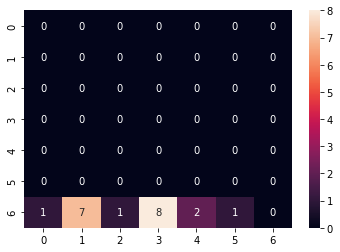

In [89]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True)

In [90]:
# %%
print(cl_report)

                  precision    recall  f1-score   support

   APR_Grassland       0.00      0.00      0.00       0.0
   AUG_Grassland       0.00      0.00      0.00       0.0
       AUG_Urban       0.00      0.00      0.00       0.0
AUG_agricultural       0.00      0.00      0.00       0.0
   JUL_Grassland       0.00      0.00      0.00       0.0
       JUL_Urban       0.00      0.00      0.00       0.0
JUL_agricultural       0.00      0.00      0.00      20.0

        accuracy                           0.00      20.0
       macro avg       0.00      0.00      0.00      20.0
    weighted avg       0.00      0.00      0.00      20.0



In [ ]:
rscv.best_params_

In [ ]:
                  precision    recall  f1-score   support

      APR_Forest       0.66      0.86      0.75        44
   APR_Grassland       0.46      0.38      0.42        34
       APR_Urban       0.78      0.50      0.61        28
APR_agricultural       0.53      0.72      0.61        36
      AUG_Forest       0.76      0.88      0.81        40
   AUG_Grassland       0.54      0.42      0.47        31
       AUG_Urban       0.71      0.65      0.68        23
AUG_agricultural       0.76      0.74      0.75        34
      JUL_Forest       0.72      1.00      0.84        26
   JUL_Grassland       0.89      0.38      0.53        21
       JUL_Urban       0.61      0.65      0.63        17
JUL_agricultural       0.64      0.82      0.72        22
      MAY_Forest       0.67      0.75      0.71        53
   MAY_Grassland       0.50      0.29      0.36        42
       MAY_Urban       0.67      0.61      0.63        33
MAY_agricultural       0.65      0.68      0.67        44

        accuracy                           0.65       528
       macro avg       0.66      0.65      0.64       528
    weighted avg       0.65      0.65      0.64       528

In [ ]:
A = {'n_estimators': 2000,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'criterion': 'gini'}